<a href="https://colab.research.google.com/github/ABTG716/EEG-Driven-Emotion-Recognition/blob/main/EEG_Driven_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/EEG/emotions.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
len(data)

2132

In [ ]:
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

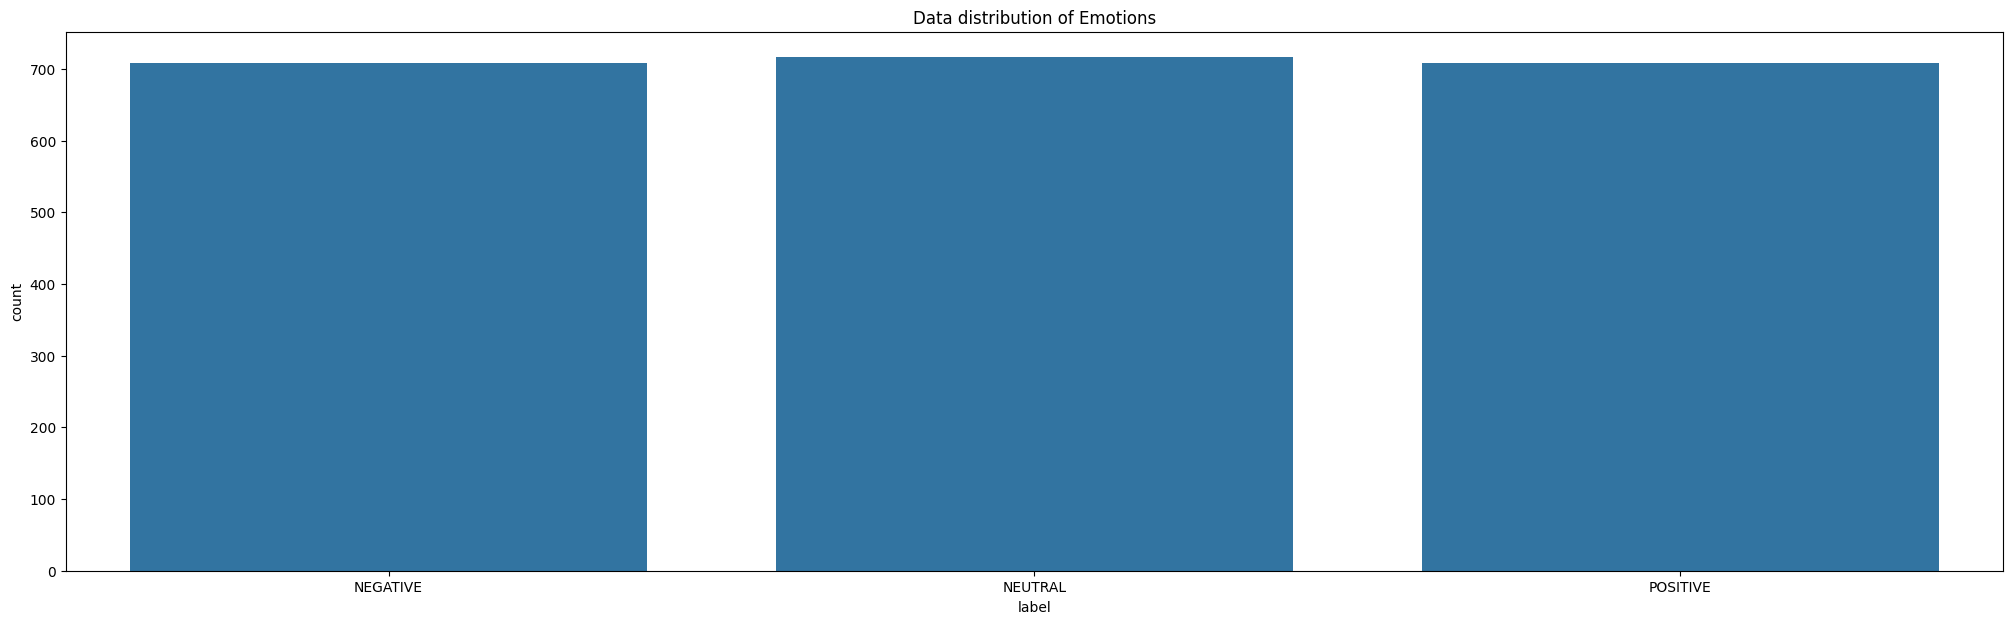

In [ ]:
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

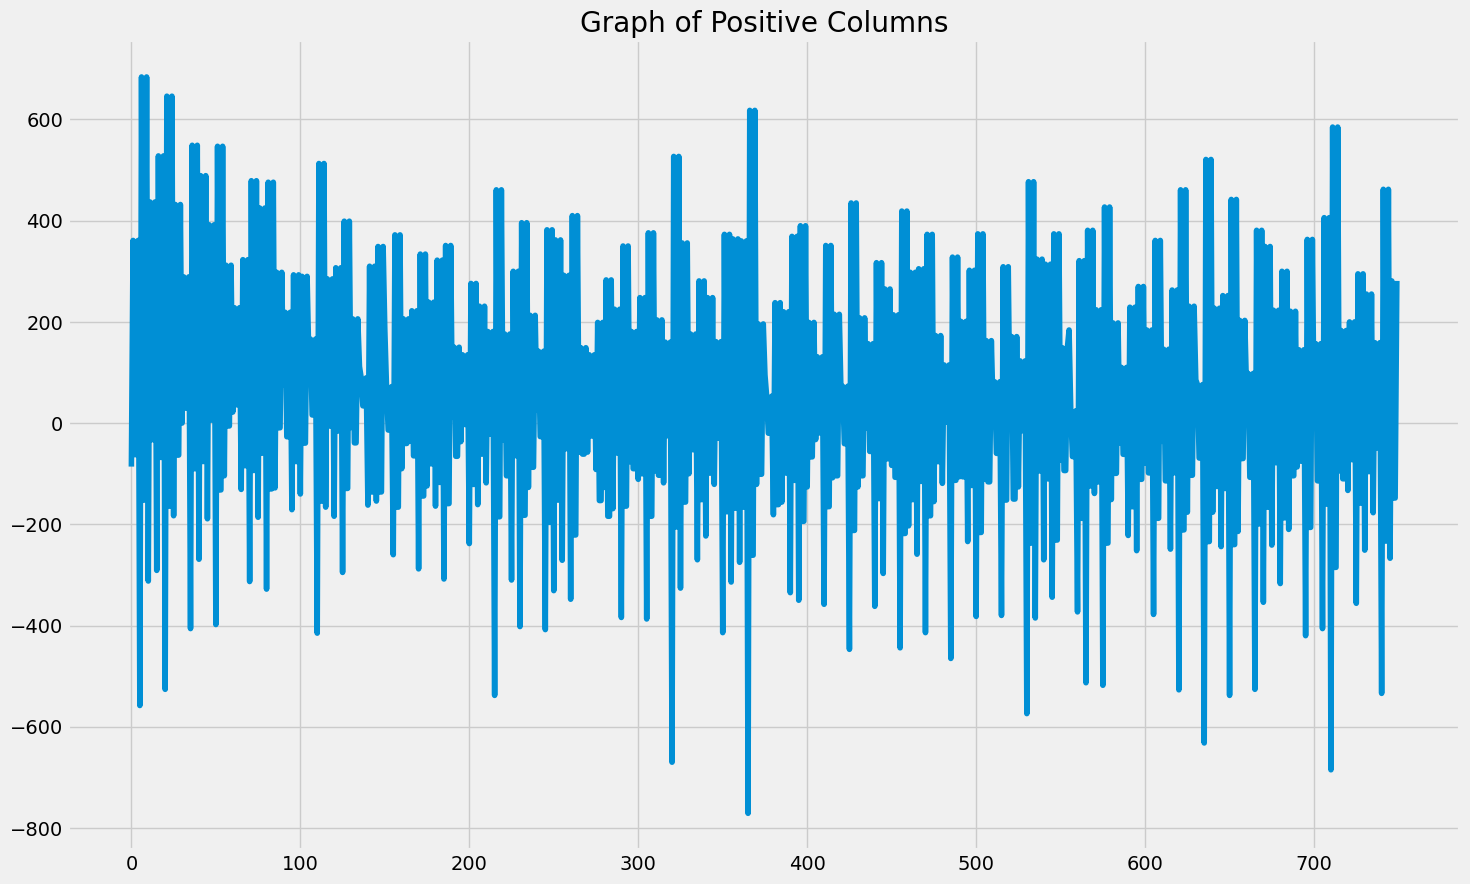

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()

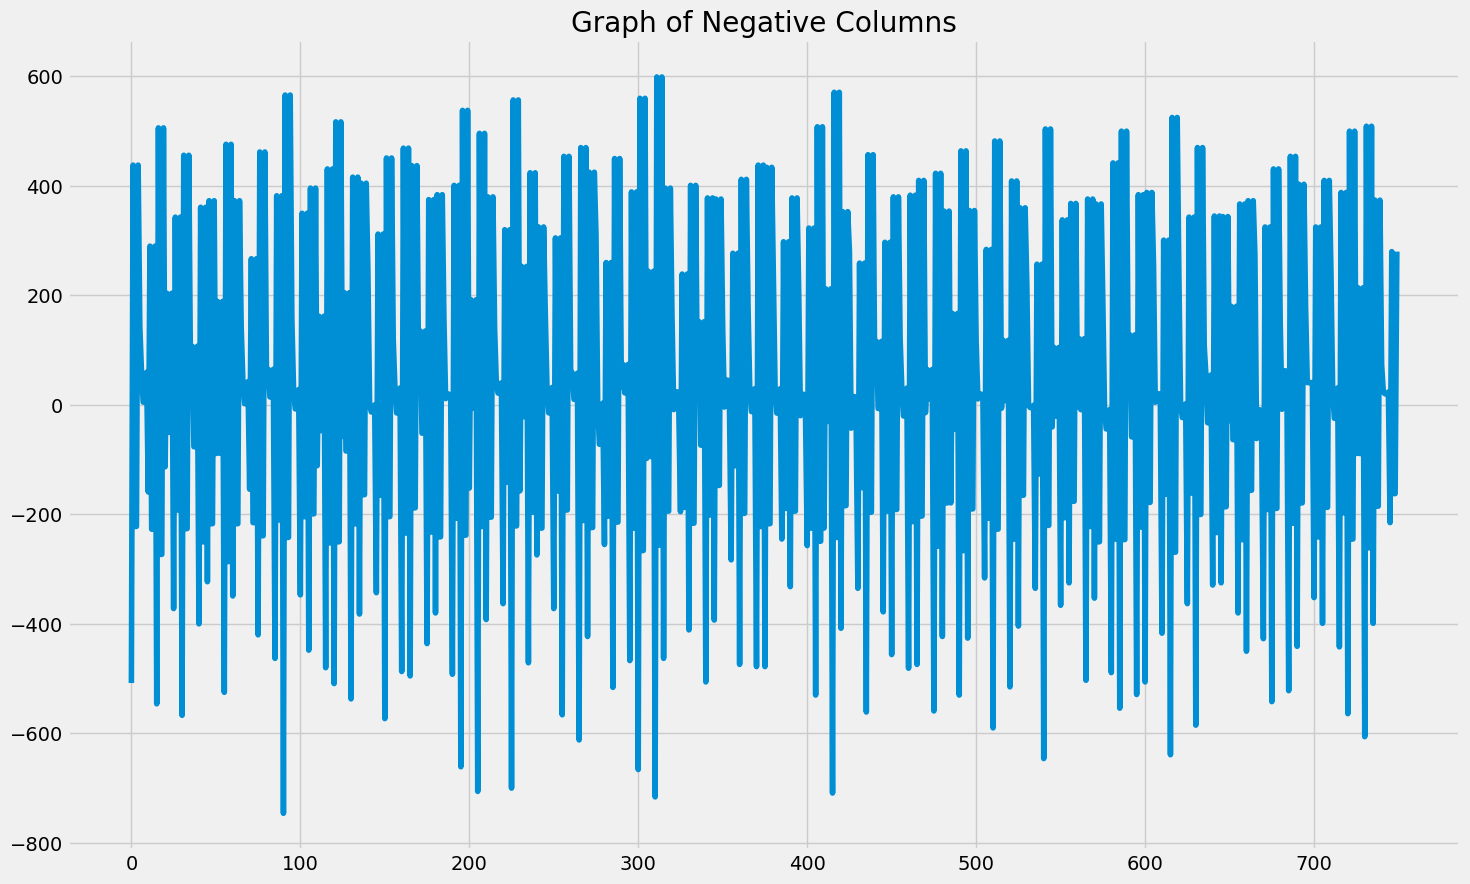

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()

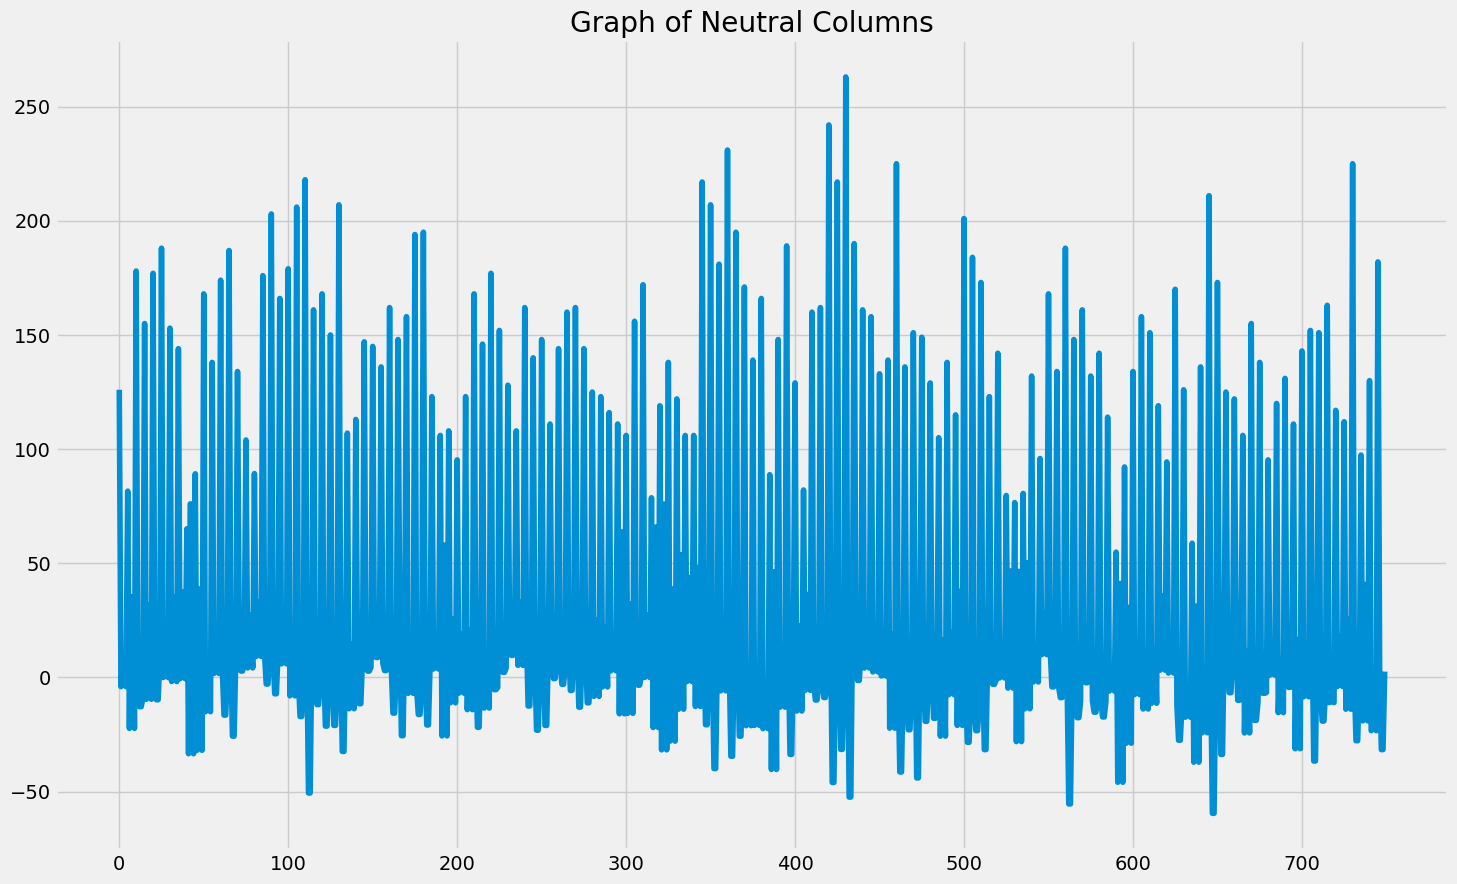

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()

In [ ]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

In [ ]:
X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

/tmp/ipython-input-16-3230731649.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(encoding_data)


In [ ]:
x_train.shape[1]

2548

In [ ]:
def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    # expand_dims = tf.expand_dims(inputs, axis=2) # Removed tf.expand_dims
    reshape_layer = tf.keras.layers.Reshape((x_train.shape[1], 1))(inputs) # Added Reshape layer

    gru = tf.keras.layers.GRU(256, return_sequences=True)(reshape_layer) # Used Reshape output
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [ ]:
lstmmodel = create_model()
#Compiling model
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2548, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 2548, 256)      │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 652288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │     1,956,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,779 (8.22 MB)

 Trainable params: 2,155,779 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 391s 8s/step - accuracy: 0.8281 - loss: 0.7034 - val_accuracy: 0.8713 - val_loss: 0.7893
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 441s 8s/step - accuracy: 0.9237 - loss: 0.3294 - val_accuracy: 0.9298 - val_loss: 0.1885
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 443s 8s/step - accuracy: 0.9567 - loss: 0.1269 - val_accuracy: 0.9240 - val_loss: 0.2137
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 471s 9s/step - accuracy: 0.9599 - loss: 0.1120 - val_accuracy: 0.9474 - val_loss: 0.1224
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 422s 8s/step - accuracy: 0.9919 - loss: 0.0420 - val_accuracy: 0.9357 - val_loss: 0.2403
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 434s 8s/step - accuracy: 0.9773 - loss: 0.0618 - val_accuracy: 0.9591 - val_loss: 0.1837
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 395s 8s/step - accuracy: 0.9934 - loss: 0.0252 - val_accuracy: 0.9415 - val_loss: 0.1333
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 444s 8s/step - accuracy: 0.9938 - loss: 0.0193 - val_accuracy: 0.9532 - v

In [ ]:
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 34.61621403694153 
Accuracy on Training: 87.82201409339905


In [ ]:
pred  = lstmmodel.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


In [ ]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
pred1 = np.argmax(pred,axis=1)

In [ ]:
y_test1 =   np.argmax(y_test,axis=1)

In [ ]:
print("Predicted:  ",pred1[:10])
print("\n")
print("Actual: ",y_test1[:10])

Predicted:   [1 2 1 2 1 1 2 0 2 1]


Actual:  [1 1 1 2 1 1 2 1 2 1]


Confusion matrix, without normalization
[[152   1   0]
 [ 22  97  23]
 [  0   6 126]]


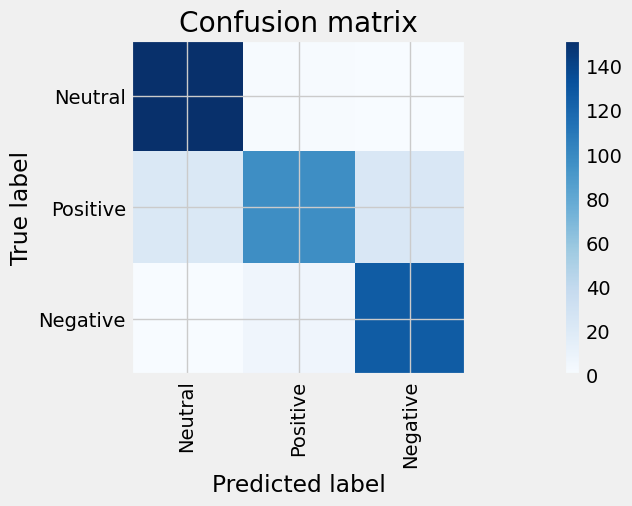

In [ ]:
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.rcParams["figure.figsize"]=(20,5)
plt.figure()
plot_confusion_matrix(cm,["Neutral","Positive","Negative"])

In [ ]:
names1 = ["Neutral","Positive","Negative"]


*		Classification Report GNB:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       153
           1       0.46      0.30      0.36       142
           2       0.81      0.66      0.73       132

    accuracy                           0.65       427
   macro avg       0.64      0.64      0.62       427
weighted avg       0.64      0.65      0.62       427


*		Classification Report SVM:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       153
           1       0.98      0.89      0.94       142
           2       0.94      0.99      0.97       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427

		Classification Report LR:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.99      0.93   

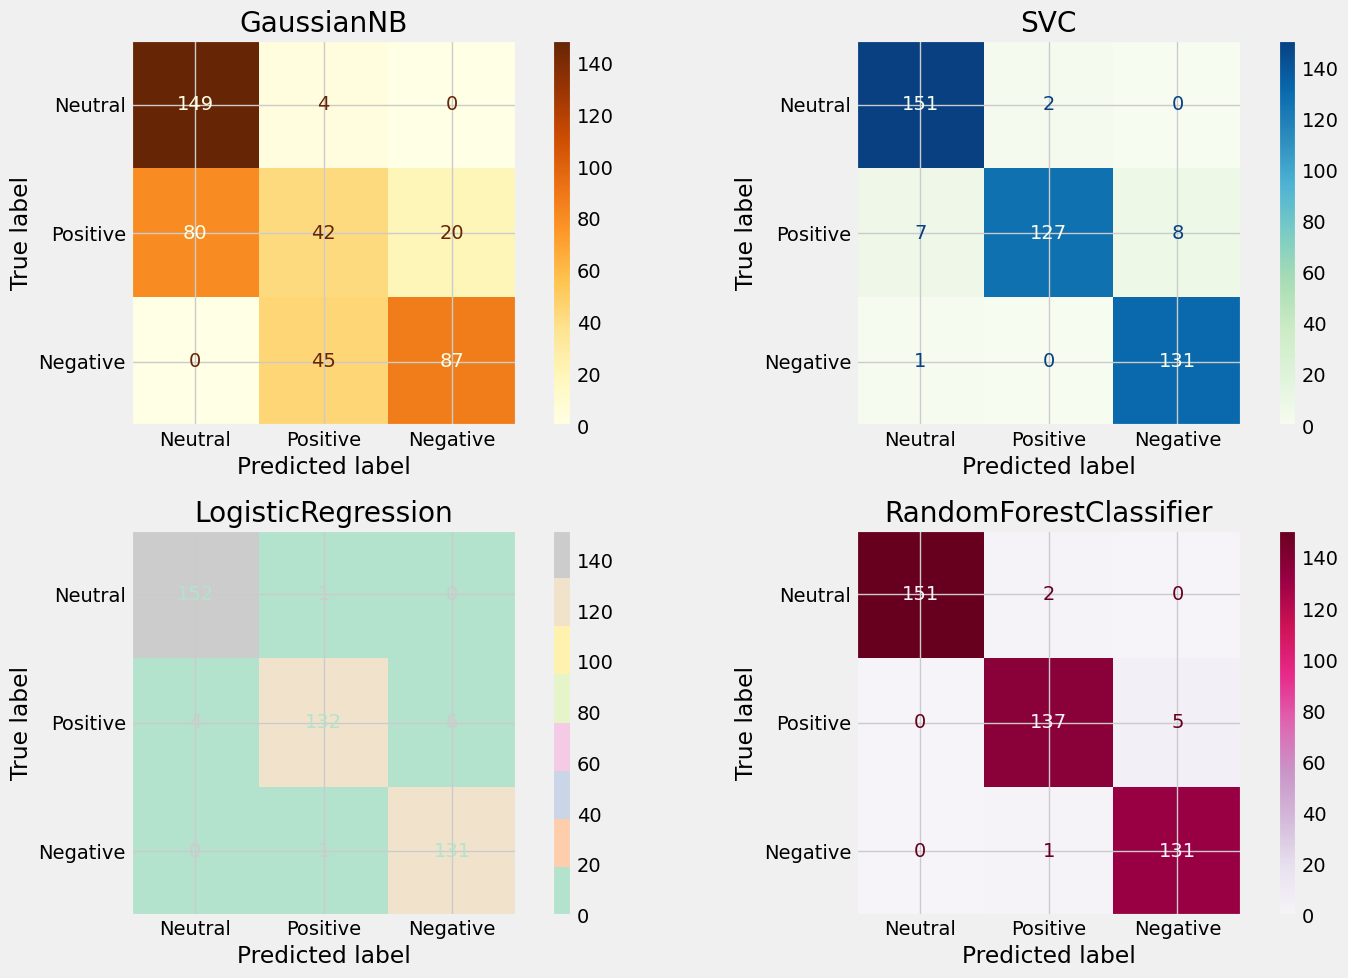

In [ ]:
Classifier_gnb = GaussianNB().fit(x_train, np.argmax(y_train,axis=1))
pred_gnb = Classifier_gnb.predict(x_test)
print ('\n*\t\tClassification Report GNB:\n', classification_report(np.argmax(y_test,axis=1), pred_gnb))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_gnb)
### Support Vector Machine

Classifier_svm = svm.SVC(kernel='linear').fit(x_train, np.argmax(y_train,axis=1))
pred_svm = Classifier_svm.predict(x_test)
print ('\n*\t\tClassification Report SVM:\n', classification_report(np.argmax(y_test,axis=1), pred_svm))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_svm)
### Logistic Regression

Classifier_LR = linear_model.LogisticRegression(solver = 'liblinear', C = 75).fit(x_train, np.argmax(y_train,axis=1))
pred_LR = Classifier_LR.predict(x_test)
print ('\t\tClassification Report LR:\n', classification_report(np.argmax(y_test,axis=1), pred_LR))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_LR)
### Decision Tree Regressor

Classifier_dt = tree.DecisionTreeClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_dt = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Deccsion Tree:\n', classification_report(np.argmax(y_test,axis=1), pred_dt))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_dt)
### Random Forest

Classifier_forest = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(x_train,np.argmax(y_train,axis=1))
pred_fr = Classifier_dt.predict(x_test)


print ('\n*\t\tClassification Report Random Forest:\n', classification_report(np.argmax(y_test,axis=1), pred_fr))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_fr)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
classifiers = [GaussianNB(),svm.SVC(kernel='linear'),
               linear_model.LogisticRegression(solver = 'liblinear', C = 75),
               RandomForestClassifier(n_estimators = 50, random_state = 0)]

colors = [ 'YlOrBr', 'GnBu', 'Pastel2', 'PuRd']
for cls, ax,c in zip(classifiers, axes.flatten(),colors):
    # Fit the classifier before making predictions for plotting
    cls.fit(x_train, np.argmax(y_train,axis=1)) # Added fit here
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test,axis=1),
                          cls.predict(x_test),
                          ax=ax,
                          cmap=c,
                         display_labels= names1)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [ ]:
print('\n*\t\tClassification Report OF Brain Waves LSTM:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))

14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step

*		Classification Report OF Brain Waves LSTM:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       153
           1       0.93      0.68      0.79       142
           2       0.85      0.95      0.90       132

    accuracy                           0.88       427
   macro avg       0.88      0.88      0.87       427
weighted avg       0.88      0.88      0.87       427



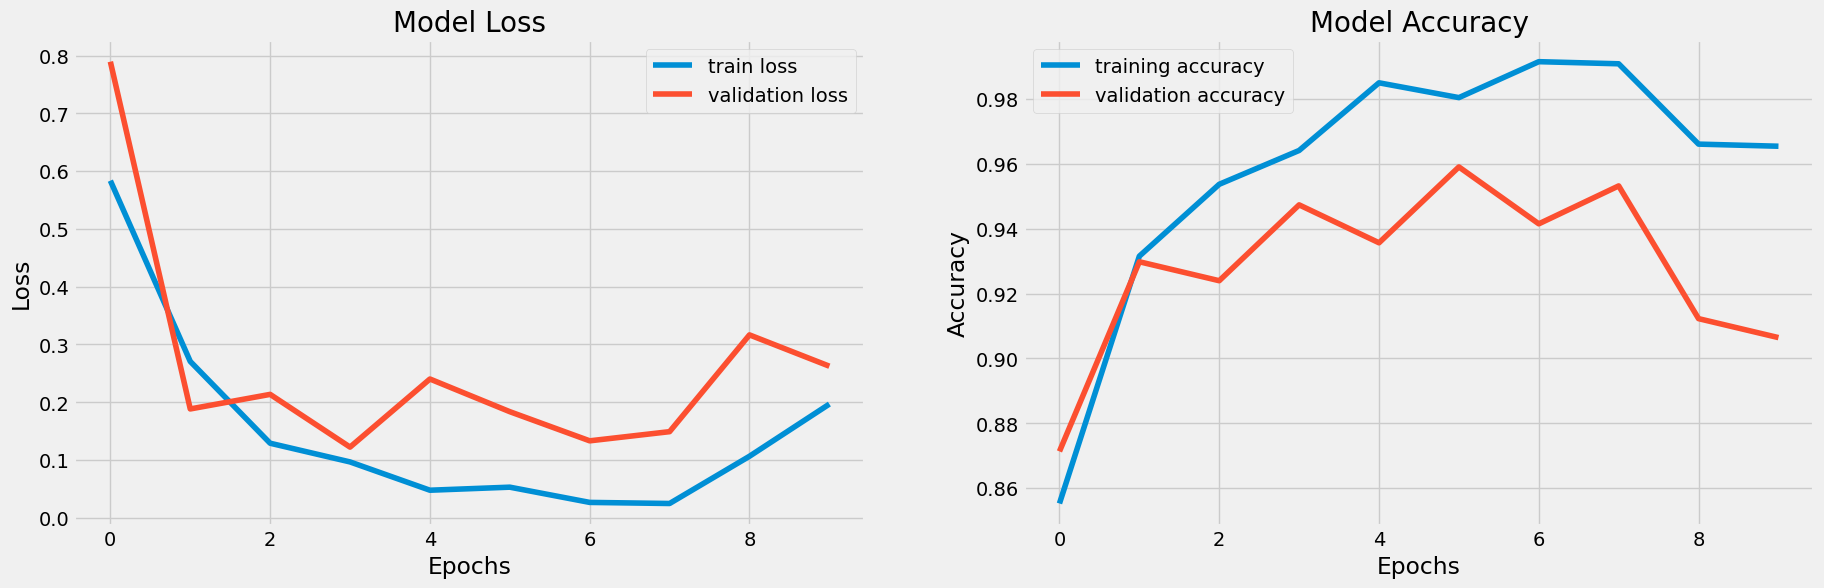

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()